In [ ]:
pip install yfinance

In [2]:
from helpers import *
import yfinance as yf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import date, timedelta, datetime

In [3]:
from options_helpers import *
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import CubicSpline

In [4]:
tomorrow = date.today() + timedelta(days=1)
annualized_rate = .05374
r = np.log(1+annualized_rate)

spx = yf.Ticker('^SPX')
ndx = yf.Ticker('^NDX')

spx_calls = spx.option_chain(tomorrow.isoformat()).calls
spx_puts = spx.option_chain(tomorrow.isoformat()).puts

ndx_calls = ndx.option_chain(tomorrow.isoformat()).calls
ndx_puts = ndx.option_chain(tomorrow.isoformat()).puts

spx_calls['midprice'] = spx_calls.apply(lambda x: (x['bid'] + x['ask'])/2, axis=1)
ndx_calls['midprice'] = ndx_calls.apply(lambda x: (x['bid'] + x['ask'])/2, axis=1)
spx_puts['midprice'] = spx_puts.apply(lambda x: (x['bid'] + x['ask'])/2, axis=1)
ndx_puts['midprice'] = ndx_puts.apply(lambda x: (x['bid'] + x['ask'])/2, axis=1)

ndx_calls = ndx_calls[['strike', 'bid', 'midprice', 'ask', 'impliedVolatility', 'inTheMoney']]
spx_calls = spx_calls[['strike', 'bid', 'midprice', 'ask', 'impliedVolatility', 'inTheMoney']]
ndx_puts = ndx_puts[['strike', 'bid', 'midprice', 'ask', 'impliedVolatility', 'inTheMoney']]
spx_puts = spx_puts[['strike', 'bid', 'midprice', 'ask', 'impliedVolatility', 'inTheMoney']]

ndx_calls['type'] = ndx_calls.apply(lambda x: 'call', axis=1)
ndx_puts['type'] = ndx_puts.apply(lambda x: 'put', axis=1)
spx_calls['type'] = spx_calls.apply(lambda x: 'call', axis=1)
spx_puts['type'] = spx_puts.apply(lambda x: 'put', axis=1)


ndx_options = pd.concat([ndx_calls, ndx_puts], ignore_index=True)
spx_options = pd.concat([spx_calls, spx_puts], ignore_index=True)

ndx_options = ndx_options[ndx_options['midprice'].isna() == False]
spx_options = spx_options[spx_options['midprice'].isna() == False]

ndx_itm = ndx_options[ndx_options['inTheMoney']==True].sort_values(by=['strike']).reset_index(drop=True)
ndx_otm = ndx_options[ndx_options['inTheMoney']==False].sort_values(by=['strike']).reset_index(drop=True)

spx_itm = spx_options[spx_options['inTheMoney']==True].sort_values(by=['strike']).reset_index(drop=True)
spx_otm = spx_options[spx_options['inTheMoney']==False].sort_values(by=['strike']).reset_index(drop=True)

In [5]:
cur_ndx_val = float(yf.Ticker('^NDX').history(period='1m').tail()['Close'])
cur_spx_val = float(yf.Ticker('^SPX').history(period='1m').tail()['Close'])

In [ ]:
spx_itm[(spx_itm['strike']>cur_spx_val*0.95) & (spx_itm['strike']<cur_spx_val*1.05)]

In [ ]:
threshold = .05

spx_itm_temp = spx_itm[(spx_itm['strike']>cur_spx_val*(1-threshold)) & (spx_itm['strike']<cur_spx_val*(1+threshold))].reset_index(drop=True)
spx_dist_dict = {}
for idx, row in spx_itm_temp.iterrows():
    if idx == 0 or idx == spx_itm_temp.shape[0]-1:
        continue
    prev_strike = float(spx_itm_temp.iloc[idx-1]['strike'])
    cur_strike = row['strike']
    next_strike = float(spx_itm_temp.iloc[idx+1]['strike'])
    
    if next_strike - cur_strike == cur_strike - prev_strike:
        cost = float(spx_itm_temp.iloc[idx-1]['midprice']) + float(spx_itm_temp.iloc[idx+1]['midprice']) - 2 * row['midprice']
        prof = cur_strike - prev_strike
        p = cost/prof
    else:
        p/=2
    spx_dist_dict[cur_strike] = max(0,p)

spx_probs_smoothed = gaussian_filter1d(list(spx_dist_dict.values()), 3)
i = 0
for k, v in spx_dist_dict.items():
    spx_dist_dict[k] = spx_probs_smoothed[i]/sum(spx_probs_smoothed)
    i+=1


ndx_itm_temp = ndx_itm[(ndx_itm['strike']>cur_ndx_val*(1-threshold)) & (ndx_itm['strike']<cur_ndx_val*(1+threshold))].reset_index(drop=True)
ndx_dist_dict = {}
for idx, row in ndx_itm_temp.iterrows():
    if idx == 0 or idx == ndx_itm_temp.shape[0]-1:
        continue
    prev_strike = float(ndx_itm_temp.iloc[idx-1]['strike'])
    cur_strike = row['strike']
    next_strike = float(ndx_itm_temp.iloc[idx+1]['strike'])
    
    if next_strike - cur_strike == cur_strike - prev_strike:
        cost = float(ndx_itm_temp.iloc[idx-1]['midprice']) + float(ndx_itm_temp.iloc[idx+1]['midprice']) - 2 * row['midprice']
        prof = cur_strike - prev_strike
        p = cost/prof
    else:
        p/=2
    ndx_dist_dict[cur_strike] = max(0,p)
    
ndx_probs_smoothed = gaussian_filter1d(list(ndx_dist_dict.values()), 3)
i = 0
for k, v in ndx_dist_dict.items():
    ndx_dist_dict[k] = ndx_probs_smoothed[i]/sum(ndx_probs_smoothed)
    i+=1

        

In [ ]:
plt.scatter(spx_dist_dict.keys(), spx_dist_dict.values())
plt.title('SPX ITM implied pdf')

In [ ]:
#P(SPX > 250 eod tommorrow?)
tups = [(sp, prob) for sp, prob in spx_dist_dict.items()]
tups.sort(key=lambda x:x[0])
cumsum = 0
for x in tups:
    if x[0] < 5160:
        cumsum+=x[1]
    else:
        print(cumsum)
        break

In [ ]:
plt.scatter(ndx_dist_dict.keys(), ndx_dist_dict.values())
plt.title('NDX ITM implied pdf')

In [50]:
threshold = .025

spx_otm_temp = spx_otm[(spx_otm['strike']>cur_spx_val*(1-threshold)) & (spx_otm['strike']<cur_spx_val*(1+threshold))].reset_index(drop=True)
spx_dist_dict = {}
for idx, row in spx_otm_temp.iterrows():
    if idx == 0 or idx == spx_otm_temp.shape[0]-1:
        continue
    prev_strike = float(spx_otm_temp.iloc[idx-1]['strike'])
    cur_strike = row['strike']
    next_strike = float(spx_otm_temp.iloc[idx+1]['strike'])
    
    if next_strike - cur_strike == cur_strike - prev_strike:
        cost = float(spx_otm_temp.iloc[idx-1]['midprice']) + float(spx_otm_temp.iloc[idx+1]['midprice']) - 2 * row['midprice']
        prof = cur_strike - prev_strike
        p = cost/prof
    else:
        p/=2
    spx_dist_dict[cur_strike] = max(0,p)

spx_probs_smoothed = gaussian_filter1d(list(spx_dist_dict.values()), 3)
i = 0
for k, v in spx_dist_dict.items():
    spx_dist_dict[k] = spx_probs_smoothed[i]/sum(spx_probs_smoothed)
    i+=1


ndx_otm_temp = ndx_otm[(ndx_otm['strike']>cur_ndx_val*(1-threshold)) & (ndx_otm['strike']<cur_ndx_val*(1+threshold))].reset_index(drop=True)
ndx_dist_dict = {}
for idx, row in ndx_otm_temp.iterrows():
    if idx == 0 or idx == ndx_otm_temp.shape[0]-1:
        continue
    prev_strike = float(ndx_otm_temp.iloc[idx-1]['strike'])
    cur_strike = row['strike']
    next_strike = float(ndx_otm_temp.iloc[idx+1]['strike'])
    
    if next_strike - cur_strike == cur_strike - prev_strike:
        cost = float(ndx_otm_temp.iloc[idx-1]['midprice']) + float(ndx_otm_temp.iloc[idx+1]['midprice']) - 2 * row['midprice']
        prof = cur_strike - prev_strike
        p = cost/prof
    else:
        p/=2
    ndx_dist_dict[cur_strike] = max(0,p)
    
ndx_probs_smoothed = gaussian_filter1d(list(ndx_dist_dict.values()), 3)
i = 0
for k, v in ndx_dist_dict.items():
    ndx_dist_dict[k] = ndx_probs_smoothed[i]/sum(ndx_probs_smoothed)
    i+=1

        

Text(0.5, 1.0, 'SPX OTM implied pdf')

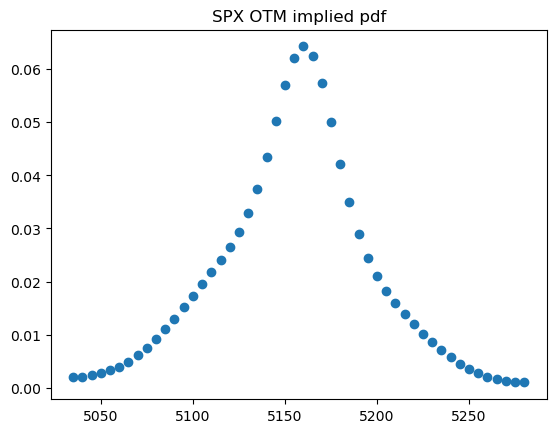

In [47]:
plt.scatter(spx_dist_dict.keys(), spx_dist_dict.values())
plt.title('SPX OTM implied pdf')

In [ ]:
#P(SPX > 5250 eod tommorrow?)
tups = [(sp, prob) for sp, prob in spx_dist_dict.items()]
tups.sort(key=lambda x:x[0])
cumsum = 0
for x in tups:
    if x[0] < 5125:
        cumsum+=x[1]
    else:
        print(cumsum)
        break

Text(0.5, 1.0, 'NDX OTM implied pdf')

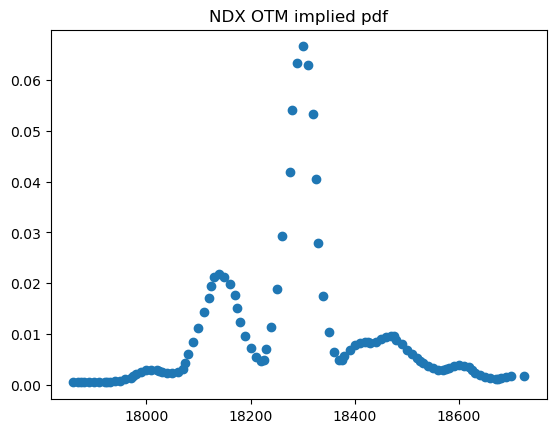

In [51]:
plt.scatter(ndx_dist_dict.keys(), ndx_dist_dict.values())
plt.title('NDX OTM implied pdf')

In [88]:
threshold = .025

spx_otm_temp = spx_otm[(spx_otm['strike']>cur_spx_val*(1-threshold)) & (spx_otm['strike']<cur_spx_val*(1+threshold))].reset_index(drop=True)
spx_otm_temp['est_iv'] = spx_otm_temp.apply(lambda x: find_vol_put(x['midprice'], cur_spx_val, x['strike'], 1/252, r) if x['type'] == 'put' else find_vol_call(x['midprice'], cur_spx_val, x['strike'], 1/252, r), axis=1)

spx_otm_temp_iv = spx_otm_temp['est_iv']
min_strike = spx_otm_temp['strike'].describe()['min']
max_strike = spx_otm_temp['strike'].describe()['max']
cs = CubicSpline(list(spx_otm_temp['strike']), spx_otm_temp_iv)
sp_in_data = list(spx_otm_temp['strike'])
x = np.linspace(min_strike, max_strike, int(max_strike - min_strike + 1))
iv_interp = cs(x)
prices_interp = []
for i in range(x.shape[0]):
    sp = x[i]
    if sp in sp_in_data:
        prices_interp.append(float(spx_otm_temp[spx_otm_temp['strike']==sp]['midprice']))
        continue
    iv = iv_interp[i]
    if sp > cur_spx_val:
        cur_price = bs_call(cur_spx_val, sp, 1/252, r, iv)
    else:
        cur_price = bs_put(cur_spx_val, sp, 1/252, r, iv)
        
    prices_interp.append(cur_price)

spx_otm_temp = pd.DataFrame({'strike': x, 'midprice': prices_interp})



spx_dist_dict = {}
for idx, row in spx_otm_temp.iterrows():
    if idx == 0 or idx == spx_otm_temp.shape[0]-1:
        continue
    prev_strike = float(spx_otm_temp.iloc[idx-1]['strike'])
    cur_strike = row['strike']
    next_strike = float(spx_otm_temp.iloc[idx+1]['strike'])
    
    if next_strike - cur_strike == cur_strike - prev_strike:
        cost = float(spx_otm_temp.iloc[idx-1]['midprice']) + float(spx_otm_temp.iloc[idx+1]['midprice']) - 2 * row['midprice']
        prof = cur_strike - prev_strike
        p = cost/prof
    else:
        p/=2
    spx_dist_dict[cur_strike] = max(0,p)

spx_probs_smoothed = gaussian_filter1d(list(spx_dist_dict.values()), 3)
i = 0
for k, v in spx_dist_dict.items():
    spx_dist_dict[k] = spx_probs_smoothed[i]/sum(spx_probs_smoothed)
    i+=1


ndx_otm_temp = ndx_otm[(ndx_otm['strike']>cur_ndx_val*(1-threshold)) & (ndx_otm['strike']<cur_ndx_val*(1+threshold))].reset_index(drop=True)
ndx_otm_temp['est_iv'] = ndx_otm_temp.apply(lambda x: find_vol_put(x['midprice'], cur_ndx_val, x['strike'], 1/252, r) if x['type'] == 'put' else find_vol_call(x['midprice'], cur_ndx_val, x['strike'], 1/252, r), axis=1)

ndx_otm_temp_iv = ndx_otm_temp['est_iv']
min_strike = ndx_otm_temp['strike'].describe()['min']
max_strike = ndx_otm_temp['strike'].describe()['max']
cs = CubicSpline(list(ndx_otm_temp['strike']), ndx_otm_temp_iv)
sp_in_data = list(ndx_otm_temp['strike'])
x = np.linspace(min_strike, max_strike, int(max_strike - min_strike + 1))
iv_interp = cs(x)
prices_interp = []
for i in range(x.shape[0]):
    sp = x[i]
    if sp in sp_in_data:
        prices_interp.append(float(ndx_otm_temp[ndx_otm_temp['strike']==sp]['midprice']))
        continue
    iv = iv_interp[i]
    if sp > cur_ndx_val:
        cur_price = bs_call(cur_ndx_val, sp, 1/252, r, iv)
    else:
        cur_price = bs_put(cur_ndx_val, sp, 1/252, r, iv)
        
    prices_interp.append(cur_price)

ndx_otm_temp = pd.DataFrame({'strike': x, 'midprice': prices_interp})
    
ndx_dist_dict = {}
for idx, row in ndx_otm_temp.iterrows():
    if idx == 0 or idx == ndx_otm_temp.shape[0]-1:
        continue
    prev_strike = float(ndx_otm_temp.iloc[idx-1]['strike'])
    cur_strike = row['strike']
    next_strike = float(ndx_otm_temp.iloc[idx+1]['strike'])
    
    if next_strike - cur_strike == cur_strike - prev_strike:
        cost = float(ndx_otm_temp.iloc[idx-1]['midprice']) + float(ndx_otm_temp.iloc[idx+1]['midprice']) - 2 * row['midprice']
        prof = cur_strike - prev_strike
        p = cost/prof
    else:
        p/=2
    ndx_dist_dict[cur_strike] = max(0,p)
    
ndx_probs_smoothed = gaussian_filter1d(list(ndx_dist_dict.values()), 3)
i = 0
for k, v in ndx_dist_dict.items():
    ndx_dist_dict[k] = ndx_probs_smoothed[i]/sum(ndx_probs_smoothed)
    i+=1

        

Text(0.5, 1.0, 'SPX OTM implied pdf with estimated iv')

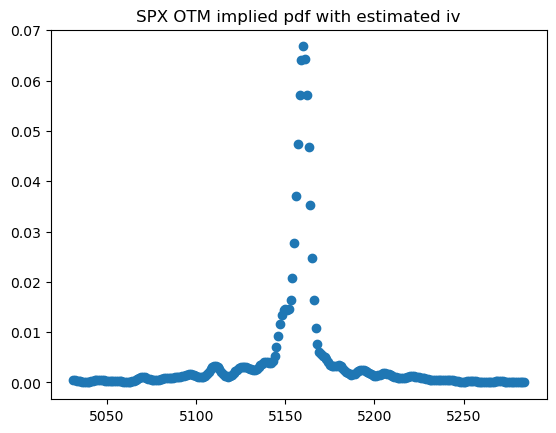

In [89]:
plt.scatter(spx_dist_dict.keys(), spx_dist_dict.values())
plt.title('SPX OTM implied pdf with estimated iv')

Text(0.5, 1.0, 'SPX OTM implied pdf')

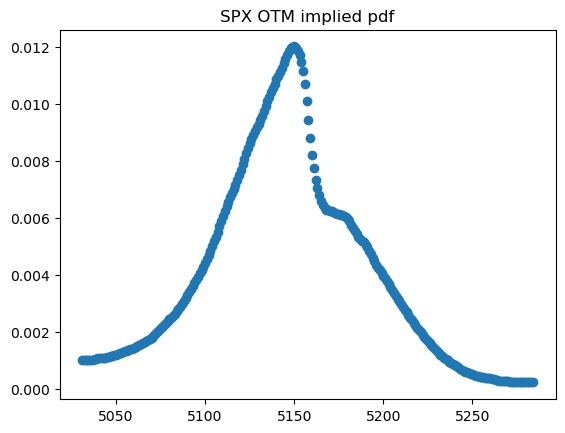

In [53]:
plt.scatter(spx_dist_dict.keys(), spx_dist_dict.values())
plt.title('SPX OTM implied pdf')

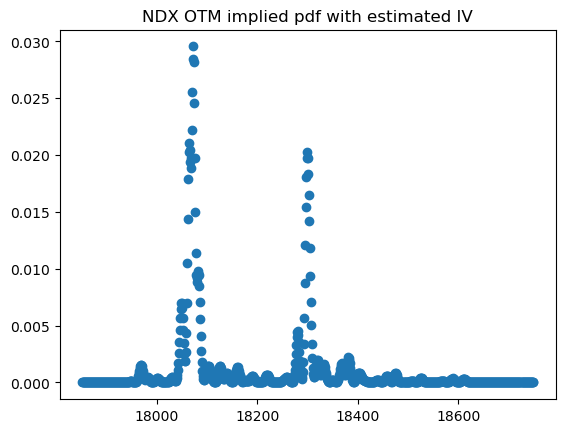

In [90]:
plt.scatter(ndx_dist_dict.keys(), ndx_dist_dict.values())
plt.title('NDX OTM implied pdf with estimated IV')
plt.show()

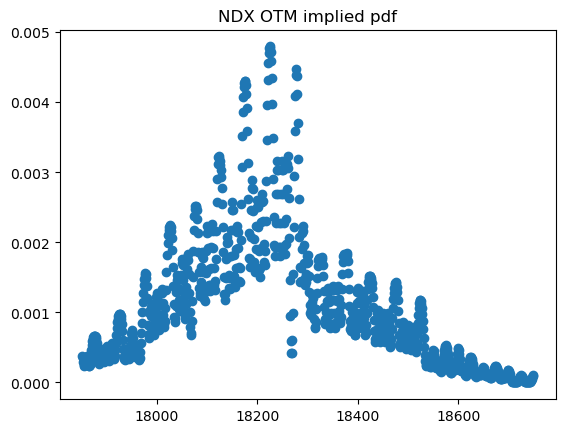

In [54]:
plt.scatter(ndx_dist_dict.keys(), ndx_dist_dict.values())
plt.title('NDX OTM implied pdf')
plt.show()

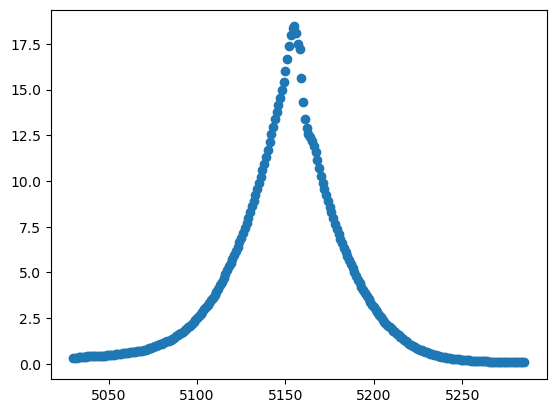

In [67]:
plt.scatter(spx_otm_temp['strike'], spx_otm_temp['midprice'])

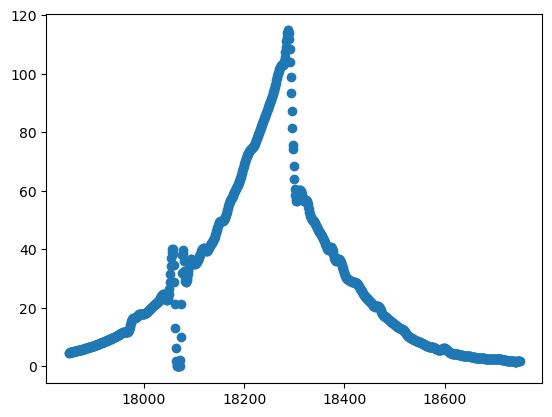

In [69]:
plt.scatter(ndx_otm_temp['strike'], ndx_otm_temp['midprice'])

In [91]:
ndx_otm_temp.iloc[200:230]

,strike,midprice
200,18050.0,2.640000e+01
201,18051.0,2.874150e+01
202,18052.0,3.150684e+01
203,18053.0,3.439404e+01
204,18054.0,3.706751e+01
205,18055.0,3.916649e+01
206,18056.0,4.031856e+01
207,18057.0,4.015707e+01
208,18058.0,3.834419e+01
209,18059.0,3.460655e+01


In [87]:
ndx_otm_temp

,strike,midprice
0,17850.0,4.725000
1,17851.0,4.760502
2,17852.0,4.797286
3,17853.0,4.835250
4,17854.0,4.874291
...,...,...
896,18746.0,1.729886
897,18747.0,1.747513
898,18748.0,1.769087
899,18749.0,1.794832


In [63]:
toy = spx_otm[(spx_otm['strike']>cur_spx_val*(1-threshold)) & (spx_otm['strike']<cur_spx_val*(1+threshold))].reset_index(drop=True)
toy['est_iv'] = toy.apply(lambda x: find_vol_put(x['midprice'], cur_spx_val, x['strike'], 1/252, r) if x['type'] == 'put' else find_vol_call(x['midprice'], cur_spx_val, x['strike'], 1/252, r), axis=1)
toy

,strike,bid,midprice,ask,impliedVolatility,inTheMoney,type,est_iv
0,5030.0,0.25,0.325,0.40,0.161263,False,put,0.185270
1,5035.0,0.30,0.375,0.45,0.158578,False,put,0.182716
2,5040.0,0.35,0.425,0.50,0.155526,False,put,0.179636
3,5045.0,0.35,0.425,0.50,0.149911,False,put,0.173101
4,5050.0,0.40,0.475,0.55,0.146432,False,put,0.169464
5,5055.0,0.45,0.525,0.60,0.142709,False,put,0.165445
6,5060.0,0.50,0.600,0.70,0.140573,False,put,0.162250
7,5065.0,0.60,0.675,0.75,0.136239,False,put,0.158539
8,5070.0,0.65,0.750,0.85,0.133187,False,put,0.154381
9,5075.0,0.85,0.925,1.00,0.131021,False,put,0.153170


In [92]:
toy = ndx_otm[(ndx_otm['strike']>cur_ndx_val*(1-threshold)) & (ndx_otm['strike']<cur_ndx_val*(1+threshold))].reset_index(drop=True)
toy['est_iv'] = toy.apply(lambda x: find_vol_put(x['midprice'], cur_ndx_val, x['strike'], 1/252, r) if x['type'] == 'put' else find_vol_call(x['midprice'], cur_ndx_val, x['strike'], 1/252, r), axis=1)
toy

,strike,bid,midprice,ask,impliedVolatility,inTheMoney,type,est_iv
0,17850.0,2.55,4.725,6.9,0.211899,False,put,0.232145
1,17860.0,2.85,5.125,7.4,0.211281,False,put,0.231591
2,17870.0,3.20,5.550,7.9,0.210457,False,put,0.230990
3,17875.0,3.40,5.750,8.1,0.209694,False,put,0.230490
4,17880.0,3.60,6.000,8.4,0.209465,False,put,0.230334
...,...,...,...,...,...,...,...,...
99,18680.0,0.30,2.700,5.1,0.171426,False,call,0.177041
100,18690.0,0.10,2.500,4.9,0.173531,False,call,0.178437
101,18700.0,1.15,2.625,4.1,0.170922,False,call,0.183724
102,18725.0,0.30,2.000,3.7,0.175942,False,call,0.184579


In [94]:
toy.iloc[15:40]

,strike,bid,midprice,ask,impliedVolatility,inTheMoney,type,est_iv
15,17975.0,12.7,16.00,19.3,0.215798,False,put,0.241582
16,17980.0,13.3,16.50,19.7,0.214844,False,put,0.241115
17,17990.0,14.5,17.90,21.3,0.215477,False,put,0.241667
18,18000.0,15.7,18.05,20.4,0.207733,False,put,0.236830
19,18010.0,17.1,19.45,21.8,0.207459,False,put,0.236901
20,18020.0,18.6,21.05,23.5,0.207863,False,put,0.237403
21,18025.0,19.3,21.80,24.3,0.207802,False,put,0.237336
22,18030.0,20.1,22.70,25.3,0.208267,False,put,0.237733
23,18040.0,21.8,24.50,27.2,0.208672,False,put,0.238246
24,18050.0,23.6,26.40,29.2,0.209061,False,put,0.238744
